<a href="https://colab.research.google.com/github/C-Ameseder/1.1.HousePricing_Regression/blob/main/house_regression_no_duplicates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> 

# Regression model on house prices

#### notebook of the Ironhack group "2 Many Males"

Lorenz, Aleksej, Markus, Christoph  
Linear regression models for a house Pricing dataset in Washington
The notebook shows the whole process incl. most of the models that have been applied ot the dataset.  

Notebook can be shared for learning purpose
</center>

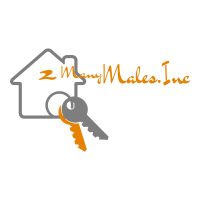

In [117]:
!pip install pygeohash
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import probplot
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import os
import sys
import pygeohash as gh

%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', 40)

We dedected some duplicates in the dataset, with the same ID, but different selleing price and different date (same house). We deleted the "earlier" rows, as we thougt there would be a unecessary bias. 

In [118]:
url = 'https://raw.githubusercontent.com/C-Ameseder/1.1.HousePricing_Regression/main/1.Data/without_duplicates_house_price_regression_toomanymales.csv'
data = pd.read_csv(url)
data_copy = pd.read_csv(url)

In [119]:

data.columns = ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price']

In [120]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


# 1. Exploratory data analysis (EDA)

## 1.1 Data types and missing values

In [121]:
def cols_dtype(df):
    """returns data types of columns of a dataframe in form of a dataframe, the values beeing the feature/variable names"""
    categoricals = df.select_dtypes(include='object').columns
    numerics = df.select_dtypes(exclude='object').columns
    booleans = df.select_dtypes(include='bool').columns
    floats = df.select_dtypes(include='float').columns
    integers = df.select_dtypes(include='int').columns
    data_types = pd.DataFrame([categoricals,numerics, booleans, floats, integers])
    data_types = data_types.T
    data_types.columns=['catergoricals or mixed', 'nuermicals', 'booleans','floats', 'integers']
    return data_types

cols_dtype(data)

,catergoricals or mixed,nuermicals,booleans,floats,integers
0,date,id,None,bathrooms,id
1,None,bedrooms,None,floors,bedrooms
2,None,bathrooms,None,lat,sqft_living
3,None,sqft_living,None,long,sqft_lot
4,None,sqft_lot,None,None,waterfront
5,None,floors,None,None,view
6,None,waterfront,None,None,condition
7,None,view,None,None,grade
8,None,condition,None,None,sqft_above
9,None,grade,None,None,sqft_basement


In [122]:
data_cols=data.columns

In [123]:
def display_missing(df):
    """shows the number of missing values of each column for a date_frame, if there is one"""
    for col in df.columns.tolist():
        if df[col].isnull().sum():
            print('{} column missing values: {}/{}'.format(col, df[col].isnull().sum(), len(df)))
    print ('Done checking for missing values')
    
display_missing(data)

Done checking for missing values


## 1.2 Correlation among X and correlation to target

In [124]:
plot = data.drop(['id', 'lat', 'long','zipcode', 'yr_renovated' ], axis=1)

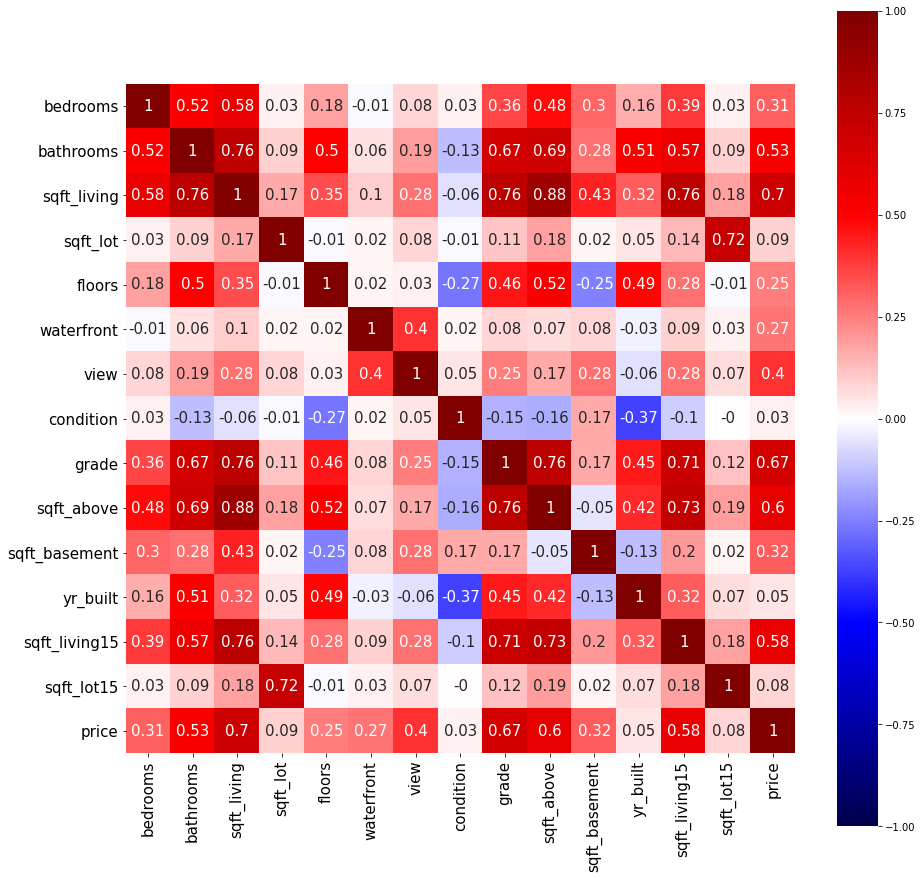

In [125]:

fig, ax = plt.subplots(figsize = (15, 15))

sns.heatmap(plot.corr().round(2),vmin=-1, vmax=1, center=0, annot = True, annot_kws = {'size':15},square=True,
cmap='seismic')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 15)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 15)
plt.show()

high correlation:  
bedrooms --> sqft_above, sqft_living  
bathrooms --> sqft_living 15, yr_built, sqft_above, floors, grade, sqft_living, bedrooms    
sqft_living --> sqft_living15, sqft_above, grade  
sqft_lot --> sqft_lot15  
floors --> sqft_above, bathrooms, grade 
grade --> sqft_living15, sqft_above, squarefoot living, bathrooms

We have a number of high correlations there. This will be a task for feeature selection and featuer engineering. Some thoughts:  
1) sqft_living and sqft_living15 measure the same things - check with filter, drop one    
2) same with sqft_lot and sqft_lot15  
3) number of bathrooms is highly realted to a number of factors, one of the main reasons for high correlation. we will fitler and see if this variable is explained by others and then drop it  
4) floors and sqft above seems highly related, we will see how many vlaues floor has and then drop one of the two

## 1.3 Target Distribution

data Price Mean: 541866.0313258637
data Price Median: 450550.0
data Price Max: 7700000
data Price Skew: 4.035304884237461


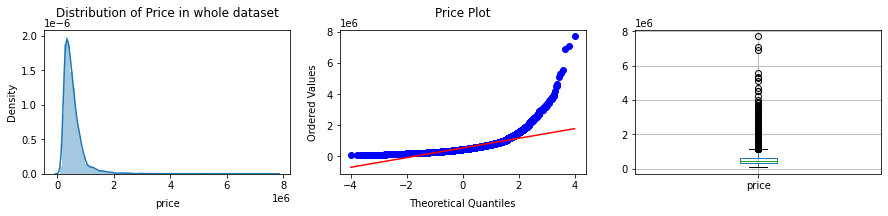

In [126]:
print('data Price Mean: {}'.format(data['price'].mean()))
print('data Price Median: {}'.format(data['price'].median()))
print('data Price Max: {}'.format(data['price'].max()))
print('data Price Skew: {}'.format(data['price'].skew()))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,2))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(data['price'], hist=True, bins = 100, ax=ax1)
probplot(data['price'], plot=ax2)
data.boxplot('price', ax=ax3)

ax1.set_xlabel('price', size=10, labelpad=8)
ax2.set_xlabel('Theoretical Quantiles', size=10, labelpad=8)
ax2.set_ylabel('Ordered Values', size=10, labelpad=8)

ax1.set_title('Distribution of Price in whole dataset', size=12, y=1.05)
ax2.set_title('Price Plot', size=12, y=1.05)

plt.show()

## 1.4 Analysis of numericals and its correaltion to target

In [127]:
plot_cols = list(plot.columns)
list_to_remove = ['date', 'waterfront', 'view','yr_built', 'sqft_living15', 'sqft_lot15']
plot_col_red = list(set(plot_cols) - set(list_to_remove))

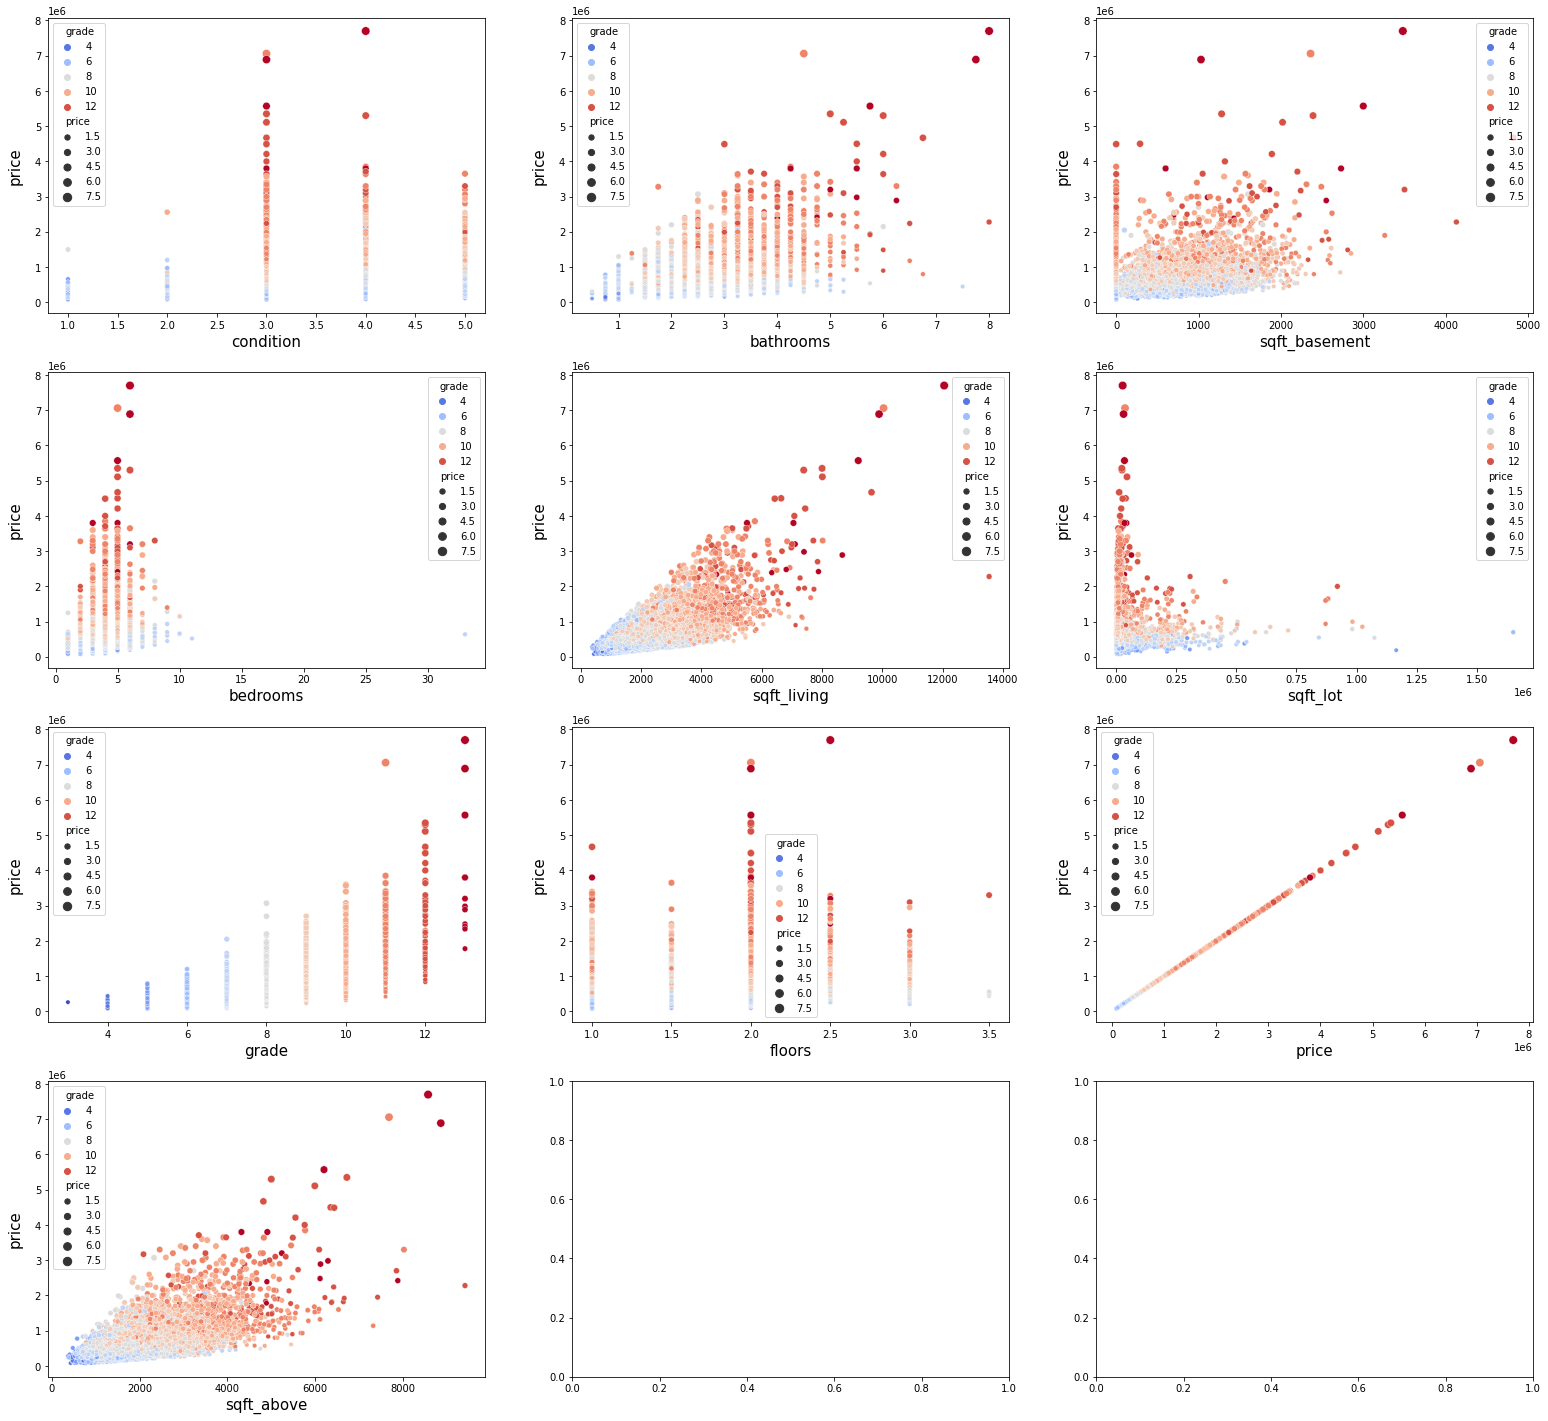

In [128]:
sns.color_palette("coolwarm", as_cmap=True)
fig,axs = plt.subplots(ncols=3, nrows=4, figsize =(15, 25))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(plot_col_red, 1):    
    plt.subplot(4, 3, i)
    sns.scatterplot(x=feature, y='price', hue='grade', palette = 'coolwarm', size='price', data=data_copy)
    plt.xlabel('{}'.format(feature), size=15)
    plt.ylabel('price', size=15, labelpad=12.5)
plt.show()


## 1.5 Pairplots to identify features for feature generation and reduction

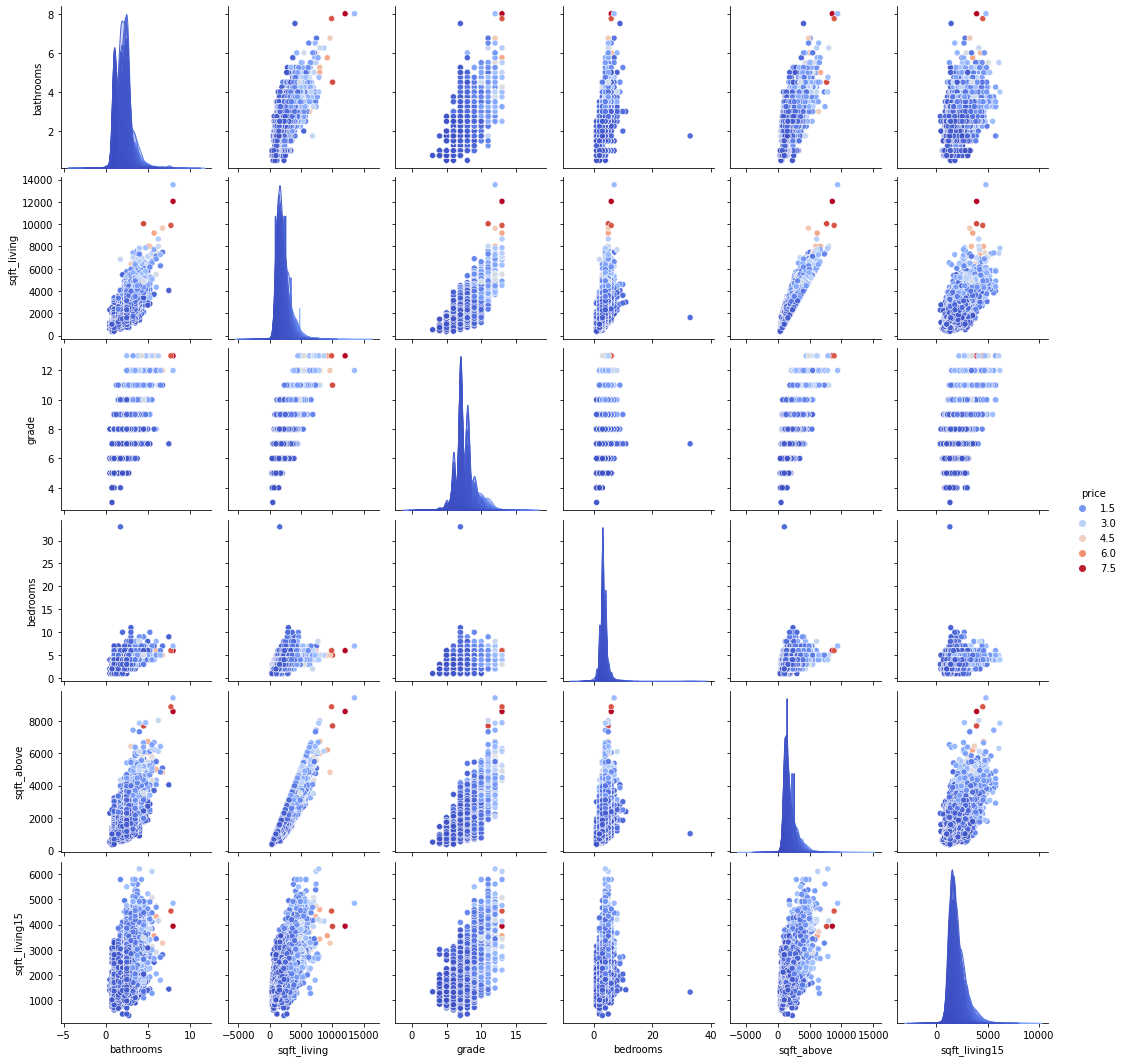

In [129]:
sns.pairplot(data[['price','bathrooms','sqft_living','grade','bedrooms','sqft_above', 'sqft_living15']],hue = 'price',palette = 'coolwarm')

## 1.6 zipcode plot for distribution of price

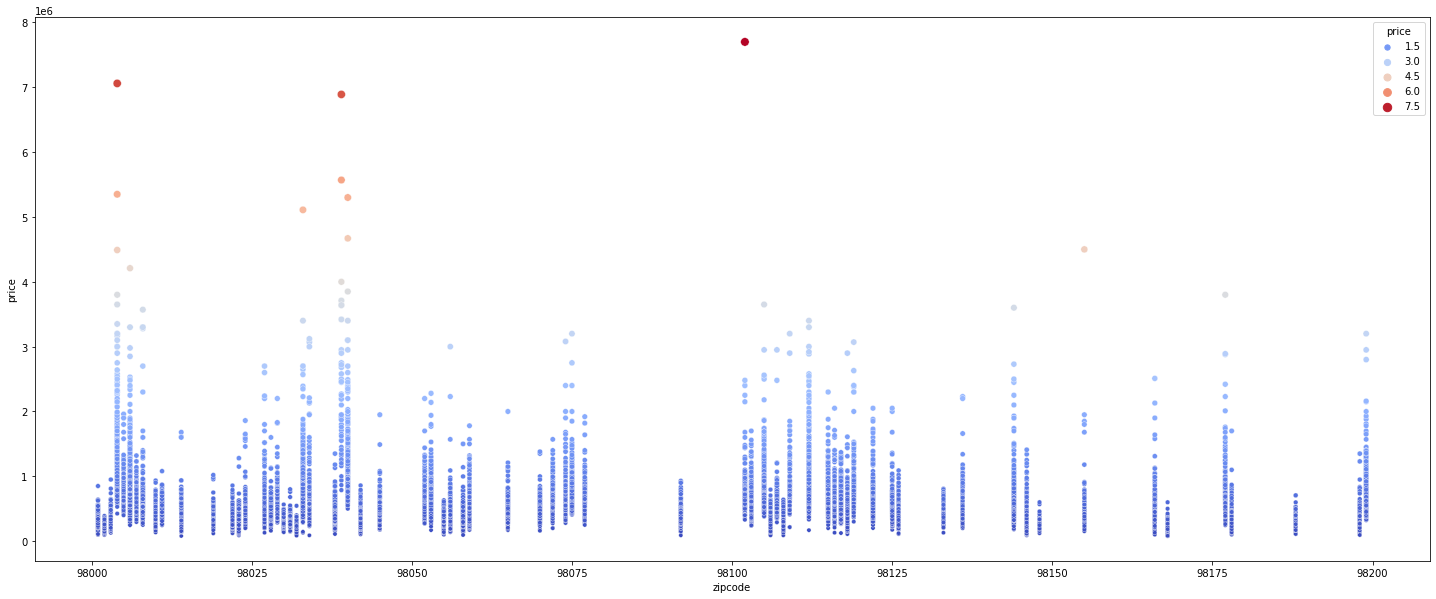

In [130]:

fig, ax = plt.subplots(figsize = (25, 10))
sns.scatterplot(x='zipcode', y='price', hue='price', palette = 'coolwarm', size='price', data=data)

# 2. Feature Engineering and Data Manipulation  
## 2.1 Extracting Categoricals
### 2.1.1 Cut zipcode by average houseprice into 5 bins

#### 2.1.1.1 Using qcut vor 5 bins, gorup by average price

In [131]:
data1=data.copy()

In [132]:
data1['avg_houseprice_region']= data1.groupby(['zipcode'])['price'].transform('mean')
#data1.head()data1.avg_houseprice.value_counts()

In [133]:
region_labels = ['very_low_prices','low_prices', 'moderate_prices', 'high_prices', 'very_high_prices']
data1['avg_houseprice_region_5'] = pd.qcut(data1['avg_houseprice_region'], 5, labels=region_labels)

2.1.1.2 cut 8 bins, using ranges group by average price

In [134]:
ranges = [0, 300000, 400000, 500000, 600000, 700000, 1000000, 2000000, np.inf]  # np.inf for infinity
labels = ['0.125', '0.25','0.375', '0.5', '0.625' ,'0.75', '0,875','1']
data1['avg_houseprice_region_new'] = pd.cut(data1['avg_houseprice_region'], 
                                  bins=ranges, 
                                  labels=labels)


In [135]:
data1.avg_houseprice_region_new.value_counts()

0.25     4511
0.625    4203
0.375    4035
0.5      3214
0.75     2389
0.125    2154
0,875     865
1          49
Name: avg_houseprice_region_new, dtype: int64

### 2.1.2 Geohash for Longitude and Latitude
Using a precision of 6.5 or 7, so we generate a norrow grit of less than 100 meters and calculate the average selleing price for each git, than bin it with pd.qcut to 9 bins baesd on average sale price.
The git has great influence on the outcome, for densly poulated areas 8 is recommended, for predictions on less poulated areas 6 or even 5.

Here is a list of the grit distance based on the precision:
#   km  
1   ±2500  
2   ±630  
3   ±78  
4   ±20  
5   ±2.4  
6   ±0.61  
7   ±0.076  
8   ±0.019  

In [136]:
data1['geohash']=data.apply(lambda x: gh.encode(x.lat, x.long, precision=6.5), axis=1)
data1.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,avg_houseprice_region,avg_houseprice_region_5,avg_houseprice_region_new,geohash
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,312850.937984,very_low_prices,0.25,c23n3cp
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,472268.447761,moderate_prices,0.375,c23p2x6
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000,462426.773050,moderate_prices,0.375,c23pdd2
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000,551768.520913,moderate_prices,0.5,c22yqfu
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000,689562.751724,very_high_prices,0.625,c23nyu3


In [137]:
data1.geohash.value_counts()

c23nxbe    15
c22zrgh    12
c23nrnr    10
c23n9pg    10
c22zpr9     9
           ..
c22ywu4     1
c23jcmk     1
c23jc4m     1
c22ywgm     1
c22zz90     1
Name: geohash, Length: 15691, dtype: int64

In [138]:
data1['avg_houseprice_geohash']= data1.groupby(['geohash'])['price'].transform('mean')

In [139]:
data1.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,avg_houseprice_region,avg_houseprice_region_5,avg_houseprice_region_new,geohash,avg_houseprice_geohash
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,312850.937984,very_low_prices,0.25,c23n3cp,297980.000000
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,472268.447761,moderate_prices,0.375,c23p2x6,489000.000000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000,462426.773050,moderate_prices,0.375,c23pdd2,180000.000000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000,551768.520913,moderate_prices,0.5,c22yqfu,769333.333333
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000,689562.751724,very_high_prices,0.625,c23nyu3,546500.000000


In [140]:
longlat_labels = ['0_gh','1_gh', '2_gh', '3_gh', '4_gh', '5_gh','6_gh', '7_gh', '8_gh']
data1['geohash_new'] = pd.qcut(data1['avg_houseprice_geohash'], 9, labels=longlat_labels)


In [141]:
data1.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,avg_houseprice_region,avg_houseprice_region_5,avg_houseprice_region_new,geohash,avg_houseprice_geohash,geohash_new
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,312850.937984,very_low_prices,0.25,c23n3cp,297980.000000,1_gh
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,472268.447761,moderate_prices,0.375,c23p2x6,489000.000000,4_gh
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000,462426.773050,moderate_prices,0.375,c23pdd2,180000.000000,0_gh
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000,551768.520913,moderate_prices,0.5,c22yqfu,769333.333333,7_gh
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000,689562.751724,very_high_prices,0.625,c23nyu3,546500.000000,5_gh


### 2.1.3 Transform sqft_basement

In [142]:
ranges = [-1, 0, 1000, 2500, np.inf]  # np.inf for infinity
labels = ['0', '0,33', '0,66', '1']
data1['sqft_basement_new'] = pd.cut(data1['sqft_basement'], 
                                  bins=ranges, 
                                  labels=labels)

#### 2.1.3.1  Transform YrBuilt

In [143]:
data1['avg_price_yr']= data.groupby(['yr_built'])['price'].transform('mean')

ranges = [300000, 400000, 500000, 600000, 700000, 800000, np.inf] 
labels = ['0', '0.2', '0.4', '0.6','0.8','1']
data1['year_new'] = pd.cut(data1['avg_price_yr'], 
                                  bins=ranges, 
                                  labels=labels)

data1['year_new']=data1['year_new'].astype(float)


### 2.1.4 Transform some numericals into 0/1
The following numericals we transform into binary categroicals.     
waterfront --> 0 for no waterfront, 1 for waterfront  
sqft_basement --> 0 for no basement, 1 for basement  
yr_renovated --> 0 for not renovated and 1 for renovated (possoble feature   generation by replacing year with buildign year  
floors --> 1 for more than 1 floor, 0 for just 1 floor  

In [144]:
data1['levels'] = data['floors'] + data['sqft_basement'].apply(lambda x: 0.5 if x>0 else 0)
data1.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,avg_houseprice_region,avg_houseprice_region_5,avg_houseprice_region_new,geohash,avg_houseprice_geohash,geohash_new,sqft_basement_new,avg_price_yr,year_new,levels
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,312850.937984,very_low_prices,0.25,c23n3cp,297980.000000,1_gh,0,451118.394737,0.2,1.0
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,472268.447761,moderate_prices,0.375,c23p2x6,489000.000000,4_gh,"0,33",543231.166667,0.4,2.5
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000,462426.773050,moderate_prices,0.375,c23pdd2,180000.000000,0_gh,0,790844.827586,0.8,1.0
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000,551768.520913,moderate_prices,0.5,c22yqfu,769333.333333,7_gh,"0,33",497411.161290,0.2,1.5
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000,689562.751724,very_high_prices,0.625,c23nyu3,546500.000000,5_gh,0,518572.304795,0.4,1.0


In [145]:
data1['waterfront'] = data['waterfront'].apply(lambda x: 1 if x > 0 else 0)
data1['sqft_basement'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
data1['yr_renovated'] = data['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
data1['view'] = data['view'].apply(lambda x: 1 if x > 0 else 0)
data1['floors'] = data['floors'].apply(lambda x: 1 if x > 1 else 0)

## 2.2 Remove Outliers

In [146]:
data1.drop(index=data[(data['bedrooms'] > 10)].index)
data1.drop(index=data[(data['bathrooms'] > 5)].index)
data1.drop(index=data[(data['price'] > 6000000)].index)
data1.shape

(21420, 31)

## 2.3 Feature combination and dealing with correlation on X

drop date, id, long, lat and zipcode as we already transformed it to categorical.
sqft_living15 and sqft_lot_15 are redundant, so we drop them

In [147]:
data1.drop(['id', 'date', 'lat', 'long', 'zipcode'], axis=1, inplace=True)

In [148]:
data1.drop(['sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

sqft_living and sqft_above are as well highly corrrealted and measure the same thiong as seen in the pairplot, we drop sqft_above

In [149]:
data1.drop(['sqft_above'], axis=1, inplace=True)

grade shows especially strong correlation ot sqft_living as well as bedrooms and bathrooms. Due to fact that grade is a strong predicter as well as sqft living we will run several models with different combinations in feature selection

The correlation of bedrooms and bathrooms to sqft living is ignored for the moment as we run several models on grade an sqft living

In [150]:
data1['bedrooms_bathr'] = data1['bedrooms']+data1['bathrooms']

## 2.4 Transformation of X and Dealing with skewness of y

As we have seen our target is highly skewed, even after removing the outliers. we therefore apply a log transforamtion

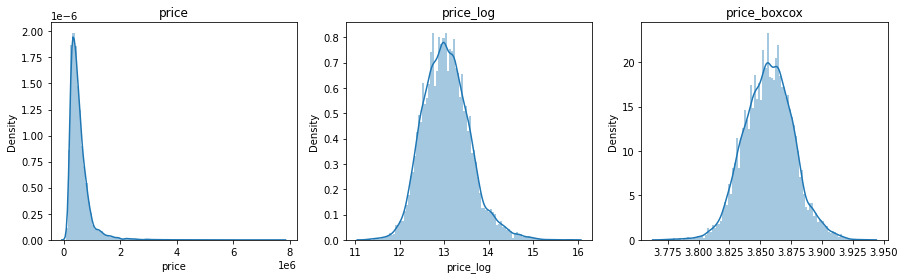

In [151]:
from scipy import stats
def feat_log_box(df, feature, bins):
    """makes a log Transformation and a boxcox transformation of a feature of a dataframe. \n
    0 values are replaced with the mean in the transformation: \n
    plots 3 distplots next to each other for comparison \n
    tales 3 arguments (df, feature, bins)"""
    df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) else np.NAN, df[feature]))
    df[feature+'_log'] = df[feature+'_log'].fillna(np.mean(df[feature+'_log']))
    df[feature+'_boxcox'] = np.where(df[feature]<=0,0,df[feature])
    mean = np.sum(df[feature+'_boxcox'])/len(df[df[feature+'_boxcox']>0])
    df[feature+'_boxcox'] = df[feature+'_boxcox'].replace(0,mean)
    xt, lmbda = stats.boxcox(df[feature+'_boxcox'])
    df[feature+'_boxcox'] = xt
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(df[feature], bins, ax=ax1)
    ax1.set_title(feature)
    sns.distplot(df[feature+'_log'], bins, ax=ax2)
    ax2.set_title(feature + '_log')
    sns.distplot(xt, bins, ax=ax3)
    ax3.set_title(feature + '_boxcox')
    
feat_log_box(data1, 'price', 100)

In [152]:
data1.drop(['price', 'price_boxcox'], axis=1, inplace = True)

In [153]:
data1.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,avg_houseprice_region,avg_houseprice_region_5,avg_houseprice_region_new,geohash,avg_houseprice_geohash,geohash_new,sqft_basement_new,avg_price_yr,year_new,levels,bedrooms_bathr,price_log
0,3,1.00,1180,5650,0,0,0,3,7,0,1955,0,312850.937984,very_low_prices,0.25,c23n3cp,297980.000000,1_gh,0,451118.394737,0.2,1.0,4.00,12.309982
1,3,2.25,2570,7242,1,0,0,3,7,1,1951,1,472268.447761,moderate_prices,0.375,c23p2x6,489000.000000,4_gh,"0,33",543231.166667,0.4,2.5,5.25,13.195614
2,2,1.00,770,10000,0,0,0,3,6,0,1933,0,462426.773050,moderate_prices,0.375,c23pdd2,180000.000000,0_gh,0,790844.827586,0.8,1.0,3.00,12.100712
3,4,3.00,1960,5000,0,0,0,5,7,1,1965,0,551768.520913,moderate_prices,0.5,c22yqfu,769333.333333,7_gh,"0,33",497411.161290,0.2,1.5,7.00,13.311329
4,3,2.00,1680,8080,0,0,0,3,8,0,1987,0,689562.751724,very_high_prices,0.625,c23nyu3,546500.000000,5_gh,0,518572.304795,0.4,1.0,5.00,13.142166


data Price_log Mean: 13.052300897517748
data Price-log Median: 13.018224331505404
data Price_log Max: 15.856730886823913
data Price_log Skew: 0.4490685842482997


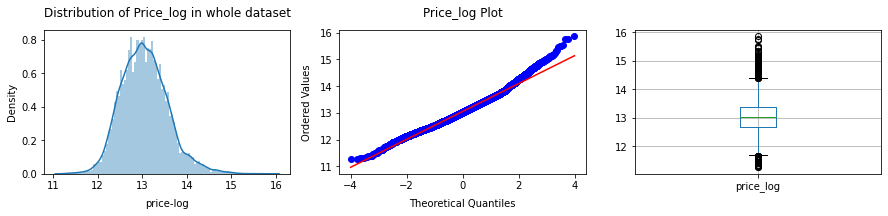

In [154]:
print('data Price_log Mean: {}'.format(data1['price_log'].mean()))
print('data Price-log Median: {}'.format(data1['price_log'].median()))
print('data Price_log Max: {}'.format(data1['price_log'].max()))
print('data Price_log Skew: {}'.format(data1['price_log'].skew()))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,2))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(data1['price_log'], hist=True, bins = 100, ax=ax1)
probplot(data1['price_log'], plot=ax2)
data1.boxplot('price_log', ax=ax3)

ax1.set_xlabel('price-log', size=10, labelpad=8)
ax2.set_xlabel('Theoretical Quantiles', size=10, labelpad=8)
ax2.set_ylabel('Ordered Values', size=10, labelpad=8)

ax1.set_title('Distribution of Price_log in whole dataset', size=12, y=1.05)
ax2.set_title('Price_log Plot', size=12, y=1.05)

plt.show()

## 2.5 Scaling and Encoding
### 2.5.1 Scaling numericals
Generating a copy of numericals and drop all variables that are categorical and that have been unsed ot gnerate categoricals. As well we drop our transfomrmed target

In [155]:
data1_nums = data1.copy()

In [156]:
data1_nums.drop(['price_log'], axis=1, inplace=True)

In [157]:
data1_nums.drop(['avg_houseprice_region','avg_houseprice_region_5', 'avg_houseprice_region_new'], axis=1, inplace=True)
data1_nums.drop(['sqft_basement_new'], axis=1, inplace=True)
data1_nums.drop(['avg_houseprice_geohash', 'geohash', 'geohash_new'], axis=1, inplace=True)

In [158]:
data1_nums.shape

(21420, 16)

#### 2.5.1.1 Standardscaler

In [159]:
transformer = StandardScaler().fit(data1_nums)
transformed = transformer.transform(data1_nums)
data1_nums_sc = pd.DataFrame(transformed)
data1_nums_sc.columns = data1_nums.columns

2.5.1.2 Normalizer

In [160]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(data1_nums)
transformed = transformer.transform(data1_nums)
data1_nums_no = pd.DataFrame(transformed)
data1_nums_no.columns = data1_nums.columns

### 2.5.2 Encoding Categoricals

In [161]:
data1_cats=data1[['avg_houseprice_region_5']]
data2_cats=data1[['avg_houseprice_region_new']]
data3_cats=data1[['sqft_basement_new']]
data4_cats=data1[['geohash_new']]

In [162]:
#data1_cats is the zipcode using 5 bins
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(data1_cats)
encoder.get_feature_names()
# encoder.categories_
encoded = encoder.transform(data1_cats).toarray()

data1_cats_enc = pd.DataFrame(encoded)
data1_cats_enc.columns = encoder.get_feature_names()

In [163]:
#data2_cats is the zipcode using 9 bins with ranges
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(data2_cats)
encoder.get_feature_names()
# encoder.categories_
encoded = encoder.transform(data2_cats).toarray()

data2_cats_enc = pd.DataFrame(encoded)
data2_cats_enc.columns = encoder.get_feature_names()

In [164]:
#data3_cats is the basement variable bined
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(data3_cats)
encoder.get_feature_names()
# encoder.categories_
encoded = encoder.transform(data3_cats).toarray()

data3_cats_enc = pd.DataFrame(encoded)
data3_cats_enc.columns = encoder.get_feature_names()
data3_cats_enc.head()


,"x0_0,33","x0_0,66",x0_1
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,0.0


In [165]:
#data4_cats is the geohash using 9 bins
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(data4_cats)
encoder.get_feature_names()
# encoder.categories_
encoded = encoder.transform(data4_cats).toarray()

data4_cats_enc = pd.DataFrame(encoded)
data4_cats_enc.columns = encoder.get_feature_names()

## 2.6 Feature Selection

YearBuilt and Condition have no big influence on y, we drop them for the moment

we now make severale dataframes for different models:  
data1_small_l: drop grade and bedrooms, bathrooms, (only use the combination)   and drop sqft lot, only use sqft living(drop grade)    
data1_small_g: same as above, onlu with grade(drop sqft_living  
data1_babe_l: use both abth and bedrooms with sqft_living  
data1_babe_g: use both bath and bedrooms with sqft_living    

based on that we proceed using dataframes 1-4 and concatinate with nums. running different models on different combinations of X 

In [166]:
#zipcode 5 bins
data1_m= pd.concat([data1_nums_sc, data1_cats_enc], axis=1)
data1_m.shape

(21420, 20)

In [167]:
data1_cats_enc.shape

(21420, 4)

In [168]:
#zipcode 8 bins with range
data2_m= pd.concat([data1_nums_sc, data2_cats_enc], axis=1)
data2_m.shape

(21420, 23)

In [169]:
data3_m= pd.concat([data2_m, data3_cats_enc], axis=1)
data3_m.shape

(21420, 26)

In [170]:
# numericlas with standardscaler and the geohash OneHotencoded
data4_m = pd.concat([data1_nums_sc,data4_cats_enc ], axis=1)
data4_m.shape

(21420, 24)

In [171]:
#trying the normalizer
data4_m_n = pd.concat([data1_nums_no, data4_cats_enc], axis=1)
data4_m_n.shape

(21420, 24)

In [172]:
# adding the beasement variable that was bined (categorical)
data5_m = pd.concat([data4_m, data3_cats_enc], axis=1)
data5_m.shape

(21420, 27)

In the follwoing we generate the specific dataframes and drop all varaibles not needed, Theses are then feeded to the train test split.

In [173]:
data1_small_l = data1_m.copy()
data1_small_l.drop(['bathrooms', 'bedrooms', 'condition', 'grade', 'yr_built', 'year_new' ], axis = 1, inplace = True)

data2_small_l = data2_m.copy()
data2_small_l.drop(['bathrooms', 'bedrooms', 'condition', 'grade', 'yr_built','year_new' ], axis = 1, inplace = True)

data1_small_g = data1_m.copy()
data1_small_g.drop(['bathrooms', 'bedrooms', 'condition', 'sqft_living', 'yr_built','year_new' ], axis = 1, inplace = True)

data2_small_g = data2_m.copy()
data2_small_g.drop(['bathrooms', 'bedrooms', 'condition', 'sqft_living', 'yr_built','year_new' ], axis = 1, inplace = True)

data1_babe_g = data1_m.copy()
data1_babe_g.drop(['bedrooms_bathr','condition', 'sqft_living', 'yr_built','year_new' ], axis = 1, inplace = True)

data2_babe_g = data2_m.copy()
data2_babe_g.drop(['bedrooms_bathr','condition', 'sqft_living', 'yr_built','year_new' ], axis = 1, inplace = True)

data1_babe_l = data1_m.copy()
data1_babe_l.drop(['bedrooms_bathr', 'condition', 'grade', 'yr_built','year_new' ], axis = 1, inplace = True)

data2_babe_l = data2_m.copy()
data2_babe_l.drop(['bedrooms_bathr', 'condition', 'grade', 'yr_built', 'year_new' ], axis = 1, inplace = True)

data2_small_lg = data2_m.copy()
data2_small_lg.drop(['bathrooms', 'bedrooms', 'condition', 'yr_built', 'year_new' ], axis = 1, inplace = True)

data3_small_lg = data3_m.copy()
data3_small_lg.drop(['bathrooms', 'bedrooms', 'condition', 'yr_built', 'sqft_basement','year_new' ], axis = 1, inplace = True)

In [174]:
data4_small_l = data4_m.copy()
data4_small_l.drop(['bathrooms', 'bedrooms', 'condition', 'yr_built', 'sqft_basement', 'grade', 'levels','year_new' ], axis = 1, inplace = True)

data4_n_small_l = data4_m_n.copy()
data4_n_small_l.drop(['bathrooms', 'bedrooms', 'condition', 'yr_built', 'sqft_basement', 'grade', 'levels','year_new' ], axis = 1, inplace = True)

data5_small_l = data5_m.copy()
data5_small_l.drop(['bathrooms', 'bedrooms', 'condition', 'yr_built', 'sqft_basement', 'grade', 'levels', 'year_new' ], axis = 1, inplace = True)

data4_xsmall_l = data4_m.copy()
data4_xsmall_l.drop(['bathrooms', 'bedrooms', 'condition', 'yr_built', 'sqft_basement', 'grade', 'sqft_lot', 'yr_renovated', 'floors' , 'levels', 'year_new', 'avg_price_yr'], axis = 1, inplace = True)

data4_xsmall_ll = data4_m.copy()
data4_xsmall_ll.drop(['bathrooms', 'bedrooms', 'condition', 'yr_built', 'sqft_basement', 'grade', 'sqft_lot', 'yr_renovated', 'floors', 'levels' ], axis = 1, inplace = True)

In [175]:
#data1_babe_yr_l = 
#data1_babe_yr_g =
#data1_babe_cond_g = 
#data1_babe_cond_l = 

# 3. Model

## 3.1 Linear Regression Model

In [176]:
y = data1['price_log']
X1_small_g = data1_small_g
X1_small_l = data1_small_l

X2_small_g = data2_small_g
X2_small_l = data2_small_l

X1_babe_g = data1_babe_g
X1_babe_l = data1_babe_l

X2_babe_g = data2_babe_g
X2_babe_l = data2_babe_l

X2_small_lg = data2_small_lg

X3_small_lg = data3_small_lg

X4_small_l = data4_small_l
X4_n_small_l = data4_n_small_l

X5_small_l = data5_small_l

X4_xsmall_l = data4_xsmall_l
X4_xsmall_ll = data4_xsmall_ll

In [177]:
from sklearn.model_selection import train_test_split
X1_small_g_train, X1_small_g_test, y1_small_g_train, y_test = train_test_split(X1_small_g, y, test_size=0.3, random_state=1)
X1_small_l_train, X1_small_l_test, y1_small_l_train, y_test = train_test_split(X1_small_l, y, test_size=0.3, random_state=1)

X2_small_g_train, X2_small_g_test, y2_small_g_train, y_test = train_test_split(X2_small_g, y, test_size=0.3, random_state=1)
X2_small_l_train, X2_small_l_test, y2_small_l_train, y_test = train_test_split(X2_small_l, y, test_size=0.3, random_state=1)


In [178]:
X1_babe_g_train, X1_babe_g_test, y1_babe_g_train, y_test = train_test_split(X1_babe_g, y, test_size=0.3, random_state=1)
X1_babe_l_train, X1_babe_l_test, y1_babe_l_train, y_test = train_test_split(X1_babe_l, y, test_size=0.3, random_state=1)

X2_babe_g_train, X2_babe_g_test, y2_babe_g_train, y_test = train_test_split(X2_babe_g, y, test_size=0.3, random_state=1)
X2_babe_l_train, X2_babe_l_test, y2_babe_l_train, y_test = train_test_split(X2_babe_l, y, test_size=0.3, random_state=1)

In [179]:
X2_small_lg_train, X2_small_lg_test, y2_small_lg_train, y_test = train_test_split(X2_small_lg, y, test_size=0.3, random_state=1)

In [180]:
X3_small_lg_train, X3_small_lg_test, y3_small_lg_train, y_test = train_test_split(X3_small_lg, y, test_size=0.3, random_state=1)

In [181]:
X4_small_l_train, X4_small_l_test, y4_small_l_train, y_test = train_test_split(X4_small_l, y, test_size=0.3, random_state=1)
X4_n_small_l_train, X4_n_small_l_test, y4_n_small_l_train, y_test = train_test_split(X4_n_small_l, y, test_size=0.3, random_state=1)

In [182]:
X5_small_l_train, X5_small_l_test, y5_small_l_train, y_test = train_test_split(X5_small_l, y, test_size=0.3, random_state=1)

In [183]:
X4_xsmall_l_train, X4_xsmall_l_test, y4_xsmall_l_train, y_test = train_test_split(X4_xsmall_l, y, test_size=0.3, random_state=1)
X4_xsmall_ll_train, X4_xsmall_ll_test, y4_xsmall_ll_train, y_test = train_test_split(X4_xsmall_ll, y, test_size=0.3, random_state=1)

In [184]:
#Data1_5bins smallx, grade
lm = linear_model.LinearRegression()
lr1_small_g= lm.fit(X1_small_g_train,y1_small_g_train)
predictions1_small_g  = lm.predict(X1_small_g_test)
r2_score(y_test, predictions1_small_g)


0.7891431109183059

In [185]:
#Data2_range bins smallX, grade
lr2_small_g= lm.fit(X2_small_g_train,y2_small_g_train)
predictions2_small_g  = lm.predict(X2_small_g_test)
r2_score(y_test, predictions2_small_g)

0.8132279468080663

In [186]:
#Data1_5bins smallx, sqft_living
lr1_small_l= lm.fit(X1_small_l_train,y1_small_l_train)
predictions1_small_l  = lm.predict(X1_small_l_test)
r2_score(y_test, predictions1_small_l)

0.7933059887536986

In [187]:
#Data2_range_bins smallx, sqft_living
lr2_small_l= lm.fit(X2_small_l_train,y2_small_l_train)
predictions2_small_l  = lm.predict(X2_small_l_test)
r2_score(y_test, predictions2_small_l)

0.8158930568241157

In [188]:
#Data1_5bins babex, grade
lm = linear_model.LinearRegression()
lr1_babe_g= lm.fit(X1_babe_g_train,y1_babe_g_train)
predictions1_babe_g  = lm.predict(X1_babe_g_test)
r2_score(y_test, predictions1_babe_g)

0.7887289706692162

In [189]:
#Data2_range bins babeX, grade
lr2_babe_g= lm.fit(X2_babe_g_train,y2_babe_g_train)
predictions2_babe_g  = lm.predict(X2_babe_g_test)
r2_score(y_test, predictions2_babe_g)

0.8127844406068522

In [190]:
#Data1_5bins babex, sqft_living
lr1_babe_l= lm.fit(X1_babe_l_train,y1_babe_l_train)
predictions1_babe_l  = lm.predict(X1_babe_l_test)
r2_score(y_test, predictions1_babe_l)

0.793040520626037

In [191]:
#Data2_range_bins babex, sqft_living
lr2_babe_l= lm.fit(X2_babe_l_train,y2_babe_l_train)
predictions2_babe_l  = lm.predict(X2_babe_l_test)
r2_score(y_test, predictions2_babe_l)

0.8156279925903775

In [192]:
#Data2_range_bins smallx, sqft_living and range
lr2_small_lg= lm.fit(X2_small_lg_train,y2_small_lg_train)
predictions2_small_lg  = lm.predict(X2_small_lg_test)
r2_score(y_test, predictions2_small_lg)

0.8356683118719416

In [193]:
#Data3_range_bins smallx, sqft_living and range basement is categoriyed
lr3_small_lg= lm.fit(X3_small_lg_train,y3_small_lg_train)
predictions3_small_lg  = lm.predict(X3_small_lg_test)
r2_score(y_test, predictions3_small_lg)

0.8364092222649077

In [194]:
#Data4_bins smallx, sqft_living ,only geohash included, no zipcode, no basement
lr4_small_l= lm.fit(X4_small_l_train,y4_small_l_train)
predictions4_small_l  = lm.predict(X4_small_l_test)
r2_score(y_test, predictions4_small_l)

0.9149712313340872

In [195]:
#Data4_range_bins smallx, sqft_living ,only geohash included, no zipcode
lr4_n_small_l= lm.fit(X4_n_small_l_train,y4_n_small_l_train)
predictions4_n_small_l  = lm.predict(X4_n_small_l_test)
r2_score(y_test, predictions4_n_small_l)

0.9098015850889734

In [196]:
#Data5_bins smallx, sqft_living, basement is categorized, only geohash included, np zipcode
lr5_small_l= lm.fit(X5_small_l_train,y5_small_l_train)
predictions5_small_l  = lm.predict(X5_small_l_test)
r2_score(y_test, predictions5_small_l)

0.9152780478049269

In [197]:
#Data4_bins xsmall, sqft_living ,only geohash included, no zipcode, no basement, no sqft_lot, no yr_renovated
lr4_xsmall_l= lm.fit(X4_xsmall_l_train,y4_xsmall_l_train)
predictions4_xsmall_l  = lm.predict(X4_xsmall_l_test)
r2_score(y_test, predictions4_xsmall_l)

0.9145227822550115

In [198]:
#Data4_bins xsmall, sqft_living ,only geohash included, no zipcode, no basement, no sqft_lot, no yr_renovated
lr4_xsmall_ll= lm.fit(X4_xsmall_ll_train,y4_xsmall_ll_train)
predictions4_xsmall_ll = lm.predict(X4_xsmall_ll_test)
r2_score(y_test, predictions4_xsmall_ll)

0.9146555269871455

# 3.2 Random Forest

In [199]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf2_small_l = RandomForestRegressor(n_estimators = 1000, random_state = 1)
# Train the model on training data
rf2_small_l.fit(X2_small_l_train, y2_small_l_train)
pred_rf2_small_l = rf2_small_l.predict(X2_small_l_test)

In [200]:
rf2_small_lg = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf2_small_lg.fit(X2_small_lg_train, y2_small_lg_train)
pred_rf2_small_lg = rf2_small_lg.predict(X2_small_lg_test)

In [201]:
rf4_xsmall_l = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf4_xsmall_l.fit(X4_xsmall_l_train, y4_xsmall_l_train)
pred_rf4_xsmall_l = rf4_xsmall_l.predict(X4_xsmall_l_test)

In [202]:
rf4_xsmall_ll = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf4_xsmall_ll.fit(X4_xsmall_ll_train, y4_xsmall_ll_train)
pred_rf4_xsmall_ll = rf4_xsmall_ll.predict(X4_xsmall_ll_test)

# 3.3 XG Boost

In [203]:
from xgboost import XGBRegressor

xg2_small_l = XGBRegressor()
xg2_small_l.fit(X2_small_l_train, y2_small_l_train)
pred_xg2_small_l = xg2_small_l.predict(X2_small_l_test)

[14:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [204]:
from xgboost import XGBRegressor

xg4_small_l = XGBRegressor()
xg4_small_l.fit(X4_small_l_train, y4_small_l_train)
pred_xg4_small_l = xg4_small_l.predict(X4_small_l_test)

[14:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# 4. Model Validation

## 4.1 Comparing different models using function

In [205]:
import sklearn.metrics as metrics

def regression_results(dic_of_models, y_true):
    '''returns a dataframe with 'Model', 'expl_variance', 'r2', 'MAE', 'MSE', 'RMSE', 'MSLE',
    need the dictionary of key='modelname', value=prediction, X_test, y_test as attributes'''
    model_val = pd.DataFrame(columns =['Model', 'expl_variance', 'r2', 'MAE', 'MSE', 'RMSE', 'MSLE'])
    # Regression metrics
    for key, y_pred in dic_of_models.items():
        explained_variance=metrics.explained_variance_score(y_true, y_pred)
        mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
        mse=metrics.mean_squared_error(y_true, y_pred) 
        mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
        median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
        r2=metrics.r2_score(y_true, y_pred)
        val_list = [key, 
                explained_variance,
                round(r2,4),
                round(mean_absolute_error,4),
                round(mse,4),
                round(np.sqrt(mse),4),
                round(mean_squared_log_error,4)]
        v_series = pd.Series(val_list, index = model_val.columns)
        model_val = model_val.append(v_series, ignore_index=True)
    return model_val

In [206]:
model_dic = {'lr1_small_g': predictions1_small_g,
             'lr1_small_l': predictions1_small_l,
             'lr2_small_g': predictions2_small_g,
             'lr2_small_l': predictions2_small_l,
             'lr1_babe_g': predictions1_babe_g,
             'lr1_babe_l': predictions1_babe_l,
             'lr2_babe_g': predictions2_babe_g,
             'lr2_babe_l': predictions2_babe_l,
             'randomforrest_2_small_l': pred_rf2_small_l,
             'xgboost2_small_l': pred_xg2_small_l,
             'lr2_small_lg': predictions2_small_lg,
             'randomforest_2_small_lg': pred_rf2_small_lg,
             'lr3_small_lg' : predictions3_small_lg,
             'lr4_small_l' : predictions4_small_l,
             'xgboost4_small_l' : pred_xg4_small_l,
             'lr4_n_small_l' : predictions4_n_small_l,
             'lr5_small_l' : predictions5_small_l,
              'lr4_xsmall_l' : predictions4_xsmall_l,
             'lr4_xsmall_ll' : predictions4_xsmall_ll,
             'randomforest_4_xsmall_l' : pred_rf4_xsmall_l,
             'randomforest_4_xsmall_ll' : pred_rf4_xsmall_ll,
             }


In [207]:
regression_results(model_dic, y_test)


,Model,expl_variance,r2,MAE,MSE,RMSE,MSLE
0,lr1_small_g,0.789228,0.7891,0.1851,0.0576,0.2401,0.0003
1,lr1_small_l,0.793468,0.7933,0.1817,0.0565,0.2377,0.0003
2,lr2_small_g,0.813325,0.8132,0.1732,0.0511,0.2259,0.0003
3,lr2_small_l,0.816060,0.8159,0.1696,0.0503,0.2243,0.0003
4,lr1_babe_g,0.788818,0.7887,0.1854,0.0577,0.2403,0.0003
5,lr1_babe_l,0.793207,0.7930,0.1819,0.0566,0.2378,0.0003
6,lr2_babe_g,0.812886,0.8128,0.1734,0.0512,0.2262,0.0003
7,lr2_babe_l,0.815800,0.8156,0.1697,0.0504,0.2245,0.0003
8,randomforrest_2_small_l,0.822856,0.8226,0.1643,0.0485,0.2202,0.0002
9,xgboost2_small_l,0.804903,0.8047,0.1730,0.0534,0.2311,0.0003


## 4.2 Selection of model
The best model so far is the linear regression lr4_xsmall_l which only has 5 variables with a accuracy of 91.6 percent:  
1) sqft_living  
2) waterfront  
3) view  
4) bedroom_bathr (combines bedrooms and bathrooms  
5) geohash ( combination of longitude and latitude, OneHot-Encoded 9 bins)  




In [208]:
X4_xsmall_l.head(2)


,sqft_living,waterfront,view,bedrooms_bathr,x0_1_gh,x0_2_gh,x0_3_gh,x0_4_gh,x0_5_gh,x0_6_gh,x0_7_gh,x0_8_gh
0,-0.982962,-0.087567,-0.330907,-1.010658,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.529902,-0.087567,-0.330907,-0.164142,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 4.3. Validating the selected model

In [209]:
def plot_errors(y, y_pred):
    
    
 #   fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,4))
  #  plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)
    fig, ax = plt.subplots()
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(7, 7)})
    plt.ylabel("Predicted 'price'")
    plt.title("Test set: Predictions against real values")
    X_plot = np.linspace(10, 16, 16)
    Y_plot = X_plot
    sns.regplot(x=y, y=y_pred, fit_reg=False, ax=ax,scatter_kws={"color": "blue", "s":1})
    plt.plot(X_plot, Y_plot, color='r',linewidth=4.)
    plt.show()
    
    sns.displot(y-y_pred, kde=True, ax=ax2)
    plt.title("Train set: Distribution of residuals")
    plt.show()

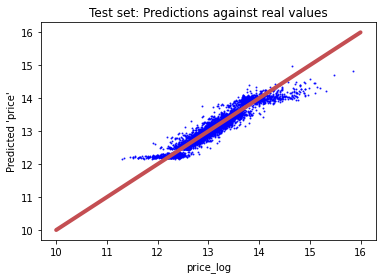

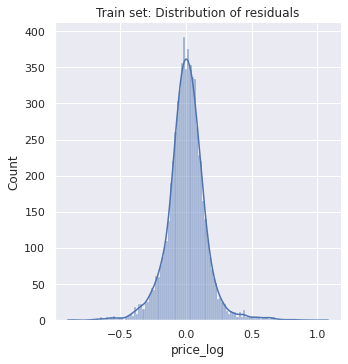

In [210]:
plot_errors(y_test, predictions4_xsmall_l )

## 4.4 Storing the model and Exports

In [211]:
import pickle
# save the model to disk
filename = 'house_regression_geohash.sav'
pickle.dump(lr4_xsmall_l, open(filename, 'wb'))



In [212]:
#from google.colab import drive
#drive.mount('/content/drive')

In [213]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### 4.4.1 Exporting files

In [214]:
data_csv = data1[['sqft_living', 'waterfront', 'view', 'bedrooms_bathr', 'geohash_new']]
data_csv['price'] = data['price']
data_csv.head()

,sqft_living,waterfront,view,bedrooms_bathr,geohash_new,price
0,1180,0,0,4.00,1_gh,221900
1,2570,0,0,5.25,4_gh,538000
2,770,0,0,3.00,0_gh,180000
3,1960,0,0,7.00,7_gh,604000
4,1680,0,0,5.00,5_gh,510000


In [215]:
data_csv.to_csv('X_y_Regr_geoh_no_dupl.csv', index = False)

In [216]:
#lr4_xsmall_l= lm.fit(X4_xsmall_l_train,y4_xsmall_l_train)
#predictions4_xsmall_l  = lm.predict(X4_xsmall_l_test)
#r2_score(y_test, predictions4_xsmall_l)
lr4_xsmall_l.coef_ 

array([8.42575374e-02, 2.77205980e-02, 1.30795303e-02, 4.13881852e-03,
       1.37370455e-03, 7.87891549e-03, 2.62841932e-01, 4.28590330e-01,
       5.84773154e-01, 7.10404142e-01, 8.40226240e-01, 9.70277569e-01,
       1.12878175e+00, 1.49046453e+00])

In [217]:
import statsmodels.api as sm

ols=sm.add_constant(X4_xsmall_l_train)
mod = sm.OLS(y4_xsmall_l_train, ols)
res = mod.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Thu, 11 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:05:48   Log-Likelihood:                 6852.8
No. Observations:               14994   AIC:                        -1.368e+04
Df Residuals:                   14981   BIC:                        -1.358e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.3367      0.004   3076.

In [218]:
sm.add_constant(X4_xsmall_l_train)

,const,sqft_living,waterfront,view,bedrooms_bathr,x0_1_gh,x0_2_gh,x0_3_gh,x0_4_gh,x0_5_gh,x0_6_gh,x0_7_gh,x0_8_gh
21412,1.0,0.475483,-0.087567,-0.330907,0.682374,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4071,1.0,0.519018,-0.087567,-0.330907,0.682374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6403,1.0,-0.602025,-0.087567,-0.330907,-0.333445,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13907,1.0,-1.255060,-0.087567,-0.330907,-0.841355,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5755,1.0,0.051010,-0.087567,-0.330907,0.005161,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,-0.634677,-0.087567,-0.330907,-1.687872,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17289,1.0,2.641382,-0.087567,-0.330907,2.375407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5192,1.0,-0.982962,-0.087567,-0.330907,-0.502749,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12172,1.0,-0.460534,-0.087567,-0.330907,-1.349265,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 4.5 Evaluation the importance of the factors in the model

Feature: 0, Score: 0.06666
Feature: 1, Score: 0.00464
Feature: 2, Score: 0.00287
Feature: 3, Score: 0.02044
Feature: 4, Score: 0.01856
Feature: 5, Score: 0.02943
Feature: 6, Score: 0.04387
Feature: 7, Score: 0.05880
Feature: 8, Score: 0.07808
Feature: 9, Score: 0.11220
Feature: 10, Score: 0.16077
Feature: 11, Score: 0.40369


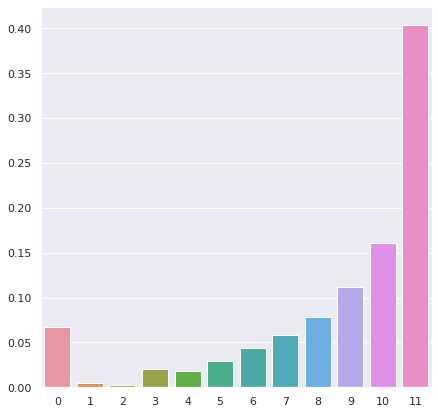

In [219]:
import matplotlib.pyplot as plt
importance = rf4_xsmall_l.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.barplot([x for x in range(len(importance))], importance)